# Can only be run on your desktop!!!

In [2]:
import keras
import numpy as np
from utils import *
import os
from keras_self_attention import *
import matplotlib.pyplot as plt
import pypianoroll
from utils import *
from glob import glob
from generator import *
from tqdm import tqdm
import subprocess
import sys
from roll import MidiFile

Using TensorFlow backend.


# Load dataset

In [3]:
import shutil

from config import datasets

sys.path.append("d:/data/magenta-1.0.2/magenta/models/score2perf/")
sys.path.append("preprocessing/")
sys.path.append("D:\\data\\magenta-1.0.2\\magenta\\music")

import encoders
import my_encoder

import transpose

import melodies_lib

import midi_io

from melody_encoder_decoder import MelodyOneHotEncoding

C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or 

C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or 

In [4]:
print(datasets)

{'HOOK_100k_melody': {'path': 'D:/data/hooktheory_dataset/00melody/HOOK_100k_melody.dat', 'shape': (93667, 64, 90)}, 'FOLK_100k_melody': {'path': 'D:/data/folkdataset/00melody/FOLK_100k_melody.dat', 'shape': (100000, 64, 58)}, 'HOOK_100k_pianoroll': {'path': 'D:/data/hooktheory_dataset/00pianoroll/HOOK_100k_pianoroll.dat', 'shape': (95661, 64, 88)}, 'FOLK_100k_pianoroll': {'path': 'D:/data/folkdataset/00pianoroll/FOLK_100k_pianoroll.dat', 'shape': (100000, 64, 56)}}


In [5]:
dataset = datasets['FOLK_100k_pianoroll']
dshape = dataset['shape']
print(dshape)
INPUT_SEQ_LEN = dshape[1]-1
print(INPUT_SEQ_LEN)

(100000, 64, 56)
63


# Load model

In [6]:
MODEL_ID = 'model_folk100k_pianoroll_bi2lstm32_attention/'
json_model = open(os.path.join(MODEL_ID,"model.json"),"r").read()
model = keras.models.model_from_json(json_model, custom_objects=SeqWeightedAttention.get_custom_objects())
model.load_weights(os.path.join(MODEL_ID, "model.h5"))
model.summary(line_length=100)

C:\Anaconda3\envs\magenta36_1\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.TextIOWrapper name='model_folk100k_pianoroll_bi2lstm32_attention/model.json' mode='r' encoding='cp1252'>
  


____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
Input (InputLayer)                           (None, 63, 56)                          0              
____________________________________________________________________________________________________
bi1 (Bidirectional)                          (None, 63, 64)                          22784          
____________________________________________________________________________________________________
bi2 (Bidirectional)                          (None, 63, 64)                          24832          
____________________________________________________________________________________________________
Attention (SeqWeightedAttention)             (None, 64)                              65             
___________________________________________________________________________________________

## Change architecture to extract attention weights

In [29]:
inputs = keras.layers.Input(
    shape=(dshape[1]-1, dshape[2],), name='Input')

lstm = keras.layers.Bidirectional(
        keras.layers.LSTM(
            32,
            dropout=0.4,
            name="LSTM",
            return_sequences=True),
        name="bi1"
    )(inputs)

lstm2 = keras.layers.Bidirectional(
    keras.layers.LSTM(
        32,
        dropout=0.4,
        name="LSTM2",
        return_sequences=True),
    name="bi2"
)(lstm)

attention = SeqWeightedAttention(
    return_attention=True, 
    name='Attention'
)
# TODO weights
attention, weights = attention(lstm2)

dense = keras.layers.Dense(
    dshape[2], activation='softmax', name="dense_outputs")(attention)

model = keras.Model(inputs=inputs, outputs=[dense, weights])

In [30]:
model.load_weights(os.path.join(MODEL_ID, "model.h5"))
model.summary(line_length=100)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
Input (InputLayer)                           (None, 63, 90)                          0              
____________________________________________________________________________________________________
bi1 (Bidirectional)                          (None, 63, 64)                          31488          
____________________________________________________________________________________________________
bi2 (Bidirectional)                          (None, 63, 64)                          24832          
____________________________________________________________________________________________________
Attention (SeqWeightedAttention)             [(None, 64), (None, 63)]                65             
___________________________________________________________________________________________

# Sampling

In [7]:
file = "d://data/folkdataset/seeds/sessiontune83.mid"
unique_name = ''.join(file.split(os.path.sep)[-1].split(".mid")[:-1])

if not os.path.exists('midi_seeds_transposed'):
    os.mkdir('midi_seeds_transposed')

transpose.main([file], os.path.abspath("midi_seeds_transposed/"))

transposed_seed = os.path.abspath(glob(os.path.join("midi_seeds_transposed",unique_name)+"*")[0])
print(transposed_seed)

transposing...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


d:\data\folkdataset\seeds\sessiontune83.mid


In [8]:
min_note, max_note = np.load(os.path.abspath(os.path.join(dataset['path'], '..', 'min_max.npy')))
print("min, max:")
print(min_note, max_note)

print('shape of sequence from pypianoroll...')
multitrack = pypianoroll.Multitrack(file, beat_resolution=4)
sequence_full = multitrack.tracks[0]
sequence_full.binarize()
sequence_full = sequence_full.pianoroll
seed_sequence = sequence_full[:,min_note:max_note+1]
print(seed_sequence.shape)

min, max:
43 98
shape of sequence from pypianoroll...
(512, 56)


In [9]:
print("padding...")
if len(seed_sequence) > INPUT_SEQ_LEN:
    seed_sequence = np.array(seed_sequence[:INPUT_SEQ_LEN])
else:
    zero_padded_seq = np.repeat(0, INPUT_SEQ_LEN)
    zero_padded_seq[INPUT_SEQ_LEN-len(seed_sequence):] = seed_sequence
    seed_sequence = zero_padded_seq
print("size after padding: ", seed_sequence.shape)

padding...
size after padding:  (63, 56)


In [10]:
np.argmax(seed_sequence,axis=1)

array([ 0,  0, 26,  0, 26, 26, 28, 28, 29, 29, 29, 29, 26, 26, 24, 24, 21,
       21, 21, 21, 19, 19, 21, 21, 17, 17, 14,  0,  0,  0, 14, 14, 26, 26,
       31,  0,  0,  0, 31, 31, 33, 33, 31, 31, 29, 29, 26, 26,  0,  0, 31,
        0, 31, 31, 33, 33, 29, 29, 26,  0, 26, 26, 24], dtype=int64)

In [11]:
def from_trim_pianoroll_to_full(seq, min_note, max_note):
    zero_sequence = np.zeros((seq.shape[0],128))
    zero_sequence[:,min_note:max_note+1] = seq
    zero_sequence[zero_sequence==1] = 127
    return zero_sequence

In [17]:
def save_trim_seq(seq,min_note,max_note,thepath):
    pypianoroll.Multitrack(tracks=[pypianoroll.Track(
        from_trim_pianoroll_to_full(seq, min_note, max_note,)
    )],beat_resolution=4).write(thepath)

In [13]:
generated = np.zeros((2*dshape[1], seed_sequence.shape[1]))

print('shape of generated ', generated.shape)

generated[:INPUT_SEQ_LEN] = seed_sequence

seed_filename = transposed_seed.split(os.path.sep)[-1].split(".mid")[0]

if not os.path.exists(os.path.join(MODEL_ID, "samples")):
    os.mkdir(os.path.join(MODEL_ID, "samples"))

samples_dir = os.path.abspath(os.path.join(MODEL_ID, "samples", seed_filename))
if not os.path.exists(samples_dir):
    os.mkdir(samples_dir)

seedpath = os.path.join(samples_dir, "1seed.mid")

print("saving seed...")
save_trim_seq(seed_sequence,min_note,max_note,seedpath)
print('seed saved at ', seedpath)

shape of generated  (128, 56)
saving seed...
seed saved at  D:\thesis_code\model_folk100k_pianoroll_bi2lstm32_attention\samples\sessiontune83\1seed.mid


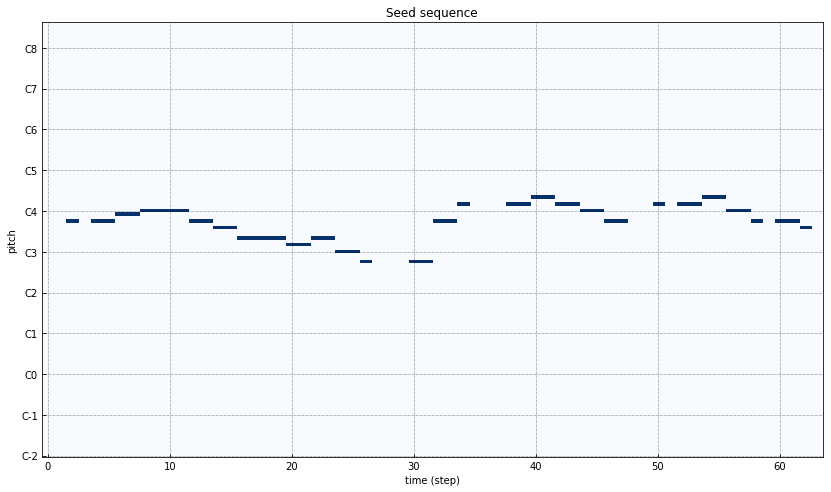

In [14]:
roll = pypianoroll.Multitrack(seedpath,beat_resolution=4).tracks[0].pianoroll
plt.figure(figsize=(14,8))
ax = plt.gca()
pypianoroll.plot_pianoroll(ax, roll)
plt.title("Seed sequence")
plt.show()

  0%|                                                                                                                                           | 0/10 [00:00<?, ?it/s]

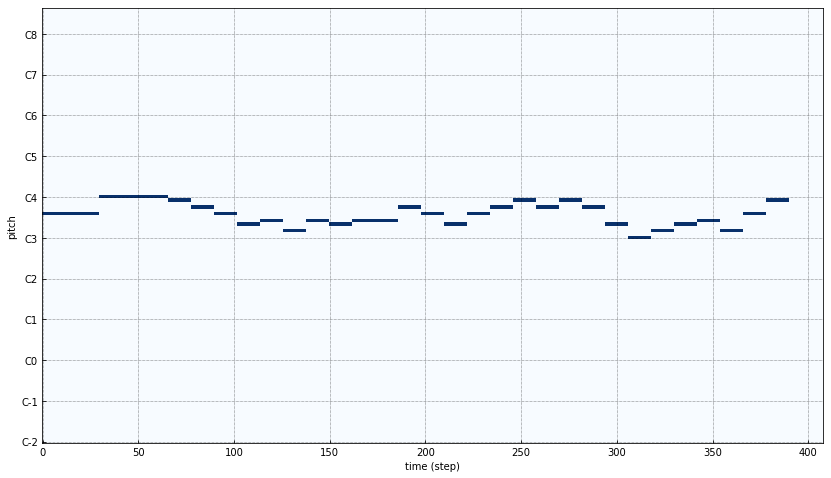

 10%|█████████████                                                                                                                      | 1/10 [00:00<00:06,  1.37it/s]

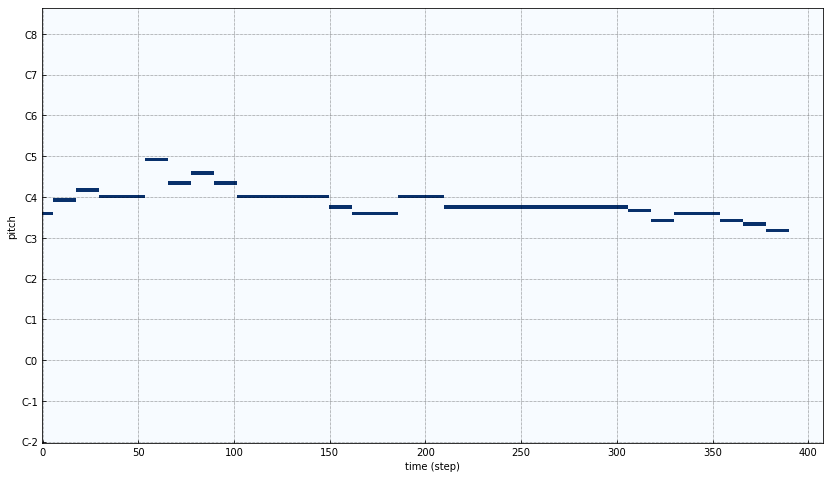

 20%|██████████████████████████▏                                                                                                        | 2/10 [00:01<00:05,  1.35it/s]

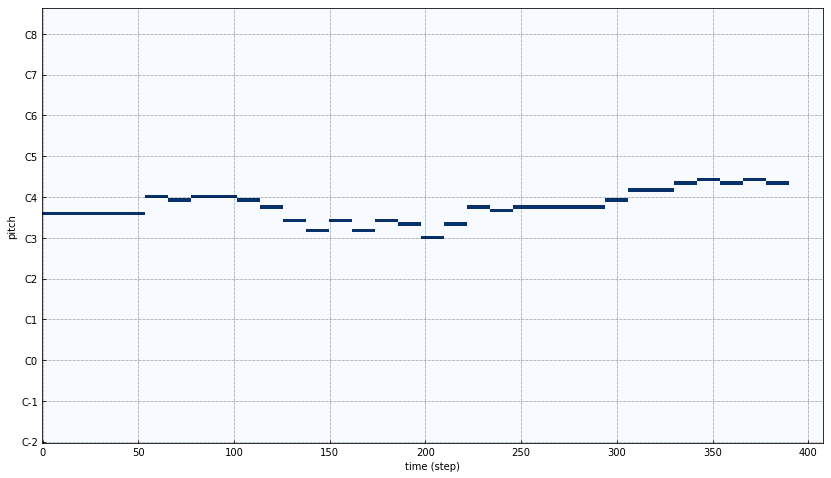

 30%|███████████████████████████████████████▎                                                                                           | 3/10 [00:02<00:05,  1.33it/s]

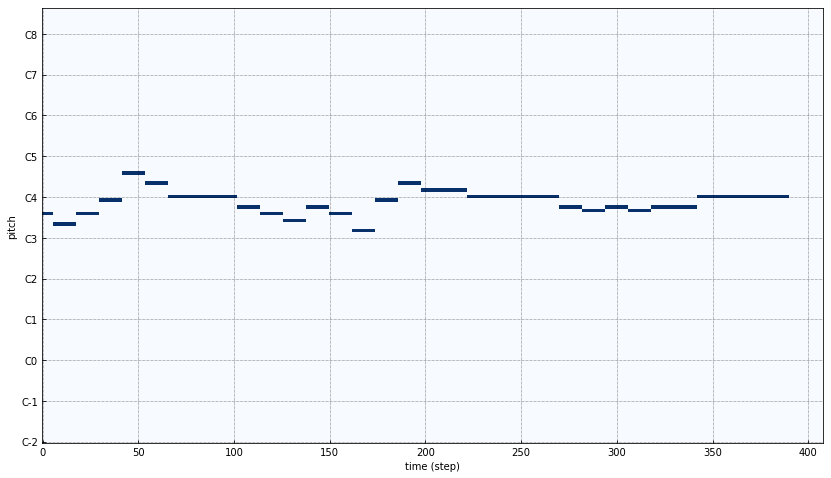

 40%|████████████████████████████████████████████████████▍                                                                              | 4/10 [00:03<00:04,  1.33it/s]

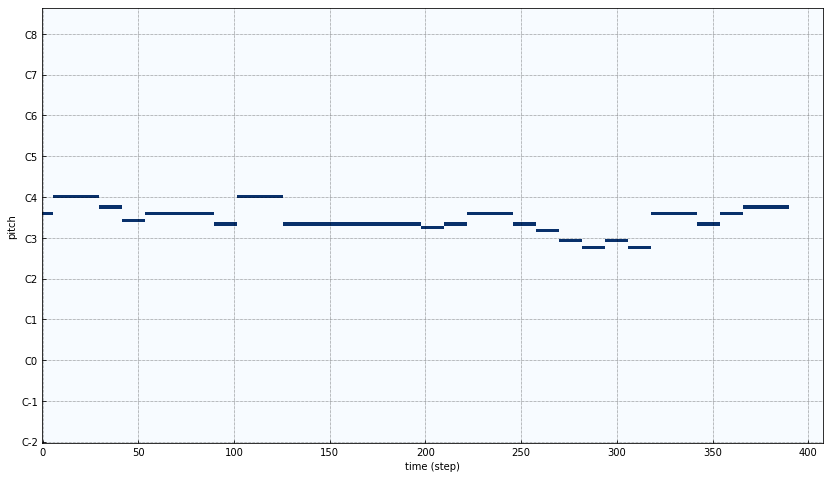

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 5/10 [00:03<00:03,  1.33it/s]

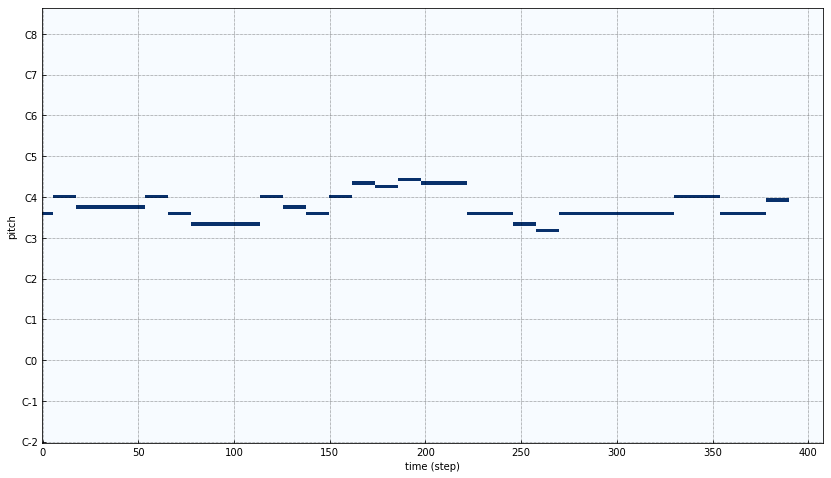

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 6/10 [00:04<00:03,  1.29it/s]

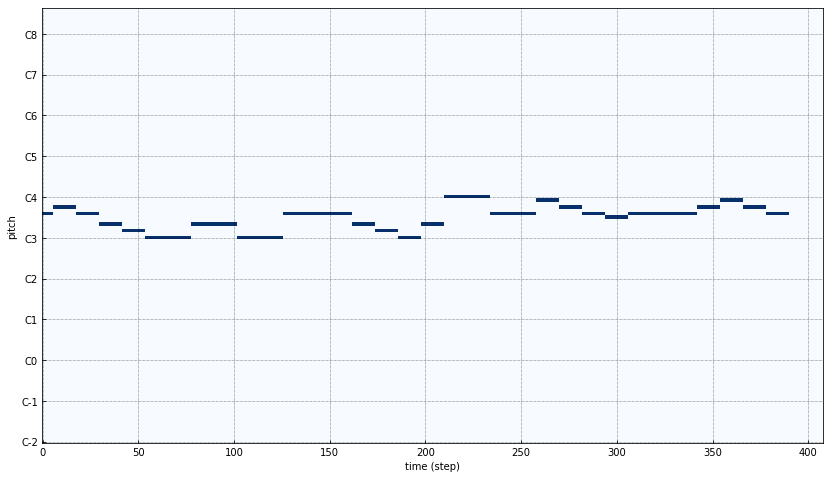

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7/10 [00:05<00:02,  1.28it/s]

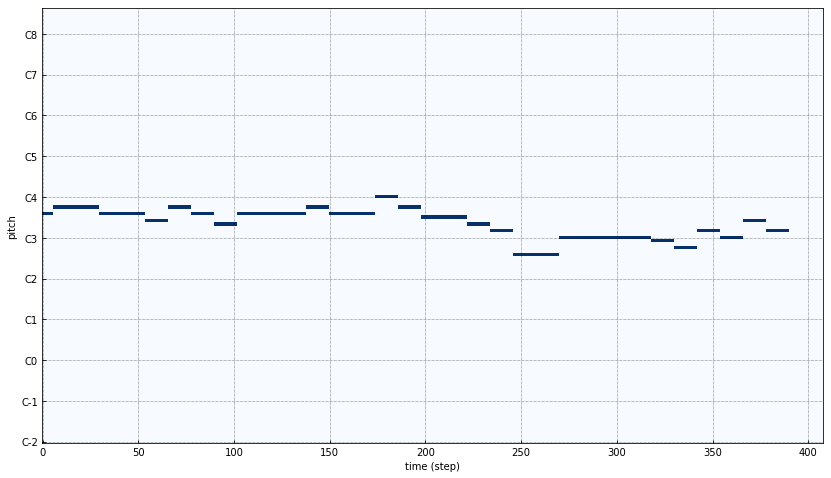

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8/10 [00:06<00:01,  1.27it/s]

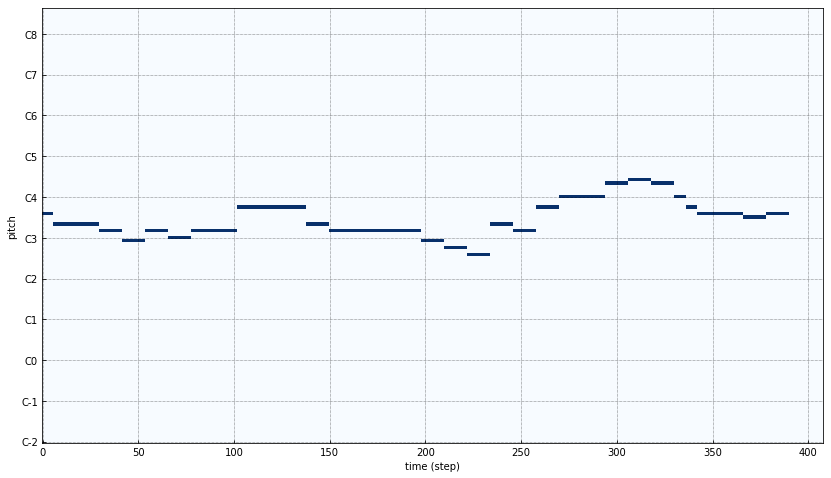

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9/10 [00:07<00:00,  1.24it/s]

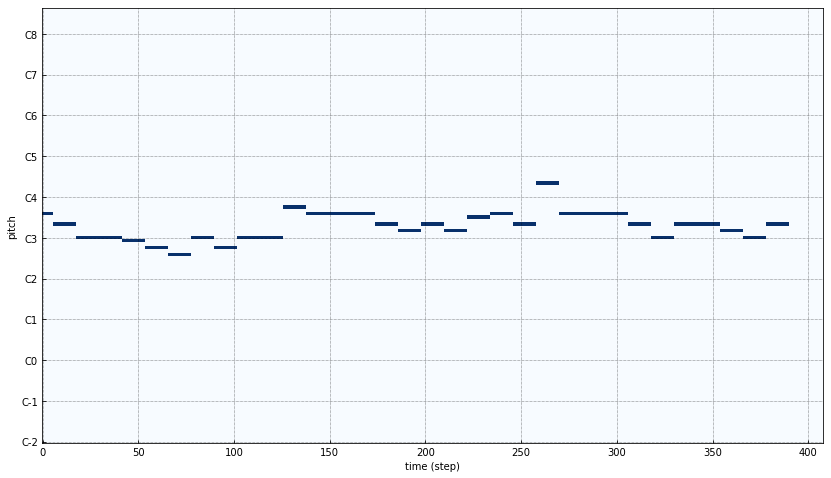

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.23it/s]


In [19]:
temperature = 1.0

nr_samples = 10

for i in tqdm(list(range(nr_samples))):
    
    for timestep in range(INPUT_SEQ_LEN, len(generated)):
        start_index = timestep - (INPUT_SEQ_LEN)
        sequence_for_prediction = generated[start_index:timestep]
#         next_step, att = sample(model, sequence_for_prediction, temperature, withatt=True)
        next_step = sample(model, sequence_for_prediction, temperature, withatt=False)
#         print(att.argsort()[-10:][::-1])
        generated[timestep] = next_step

    generated_noseed = generated[INPUT_SEQ_LEN:]
    
    new_path = os.path.join(samples_dir, "temp_%s_%s.mid" %(temperature, i))    
    save_trim_seq(generated_noseed,min_note,max_note,new_path)
    
    roll = pypianoroll.Multitrack(new_path).tracks[0]
    plt.figure(figsize=(14,8))
    ax = plt.gca()
    pypianoroll.plot_pianoroll(ax, roll.pianoroll)
    plt.show()